### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf

from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [2]:
np.random.seed(123)

tf.set_random_seed(123)

Get current working directory

In [3]:
PATH = os.getcwd()

Change directory

In [4]:
os.chdir(PATH)

#### Loading the data

In [5]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [6]:
data.shape

(61589, 23)

Display the columns

In [7]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [8]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [9]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

    For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

        The top is the most common value.

        The freq is the most common value’s frequency.

In [10]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [11]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [12]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [13]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61589 entries, 0 to 61588
Data columns (total 23 columns):
sku                  61589 non-null category
national_inv         61589 non-null int64
lead_time            58186 non-null float64
in_transit_qty       61589 non-null int64
forecast_3_month     61589 non-null int64
forecast_6_month     61589 non-null int64
forecast_9_month     61589 non-null int64
sales_1_month        61589 non-null int64
sales_3_month        61589 non-null int64
sales_6_month        61589 non-null int64
sales_9_month        61589 non-null int64
min_bank             61589 non-null int64
potential_issue      61589 non-null category
pieces_past_due      61589 non-null int64
perf_6_month_avg     61589 non-null float64
perf_12_month_avg    61589 non-null float64
local_bo_qty         61589 non-null int64
deck_risk            61589 non-null category
oe_constraint        61589 non-null category
ppap_risk            61589 non-null category
stop_auto_buy        61589 non

##### Delete sku attribute

In [15]:
np.size(np.unique(data.sku))

61589

In [16]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [17]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [18]:
print (data.shape)

(61589, 22)


Since the number of missing values is about 5%. For initial analysis we ignore all these records

In [19]:
data = data.dropna(axis=0)

In [20]:
print(data.isnull().sum())
print("----------------------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
----------------------------------
(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and ANN model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [21]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [22]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [23]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, 
                      prefix_sep="_",drop_first=True)

In [24]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [25]:
pd.value_counts(data['went_on_backorder_Yes'])

0    47217
1    10969
Name: went_on_backorder_Yes, dtype: int64

In [26]:
pd.value_counts(data['went_on_backorder_Yes'])/data['went_on_backorder_Yes'].count() * 100

0    81.148386
1    18.851614
Name: went_on_backorder_Yes, dtype: float64

#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [27]:
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123,
                                                    stratify = data['went_on_backorder_Yes'])

In [28]:
print(X_train.shape)
print(X_test.shape)

(40730, 21)
(17456, 21)


In [29]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33052
1     7678
dtype: int64
0    14165
1     3291
dtype: int64


In [30]:
print(pd.value_counts(y_train)/y_train.size * 100)
print(pd.value_counts(y_test)/y_test.size * 100)

0    81.14903
1    18.85097
dtype: float64
0    81.146884
1    18.853116
dtype: float64


### Perceptron Model

In [31]:
np.random.seed(123)

tf.set_random_seed(123)

In [32]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=21, activation='sigmoid', kernel_initializer='normal'))

In [33]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [34]:
perceptron_model_history = perceptron_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 31us/step - loss: 2.4028 - acc: 0.7951 - val_loss: 3.0461 - val_acc: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 18us/step - loss: 2.8948 - acc: 0.8124 - val_loss: 3.0160 - val_acc: 0.8032
Epoch 3/100
32584/32584 [==============================] - 1s 19us/step - loss: 2.8444 - acc: 0.8071 - val_loss: 2.9248 - val_acc: 0.7932
Epoch 4/100
32584/32584 [==============================] - 1s 19us/step - loss: 2.7676 - acc: 0.8072 - val_loss: 2.8893 - val_acc: 0.8022
Epoch 5/100
32584/32584 [==============================] - 1s 21us/step - loss: 2.7160 - acc: 0.8022 - val_loss: 2.8203 - val_acc: 0.7955
Epoch 6/100
32584/32584 [==============================] - 1s 22us/step - loss: 2.3445 - acc: 0.8053 - val_loss: 2.9778 - val_acc: 0.7943
Epoch 7/100
32584/32584 [==============================] - 1s 20us/step - loss: 2.5351 - acc: 0.8069 - val_loss: 3.0310 - v

32584/32584 [==============================] - 1s 18us/step - loss: 1.0166 - acc: 0.8728 - val_loss: 2.8451 - val_acc: 0.7957
Epoch 60/100
32584/32584 [==============================] - 1s 16us/step - loss: 1.4751 - acc: 0.8489 - val_loss: 0.9109 - val_acc: 0.8610
Epoch 61/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.9999 - acc: 0.8708 - val_loss: 0.7262 - val_acc: 0.8866
Epoch 62/100
32584/32584 [==============================] - 1s 16us/step - loss: 1.2642 - acc: 0.8618 - val_loss: 0.7787 - val_acc: 0.8953
Epoch 63/100
32584/32584 [==============================] - 1s 16us/step - loss: 1.2681 - acc: 0.8596 - val_loss: 1.0871 - val_acc: 0.8548
Epoch 64/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.9761 - acc: 0.8724 - val_loss: 0.8480 - val_acc: 0.8698
Epoch 65/100
32584/32584 [==============================] - 1s 17us/step - loss: 1.2123 - acc: 0.8658 - val_loss: 0.8332 - val_acc: 0.8801
Epoch 66/100
32584/32584 [==============

##### Plot

In [35]:
print(perceptron_model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


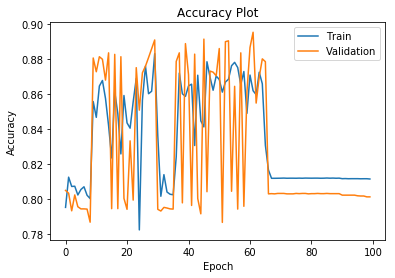

In [36]:
plt.plot(perceptron_model_history.history['acc'])
plt.plot(perceptron_model_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

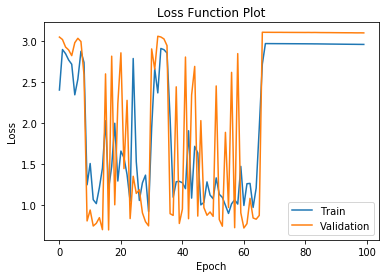

In [37]:
plt.plot(perceptron_model_history.history['loss'])
plt.plot(perceptron_model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

##### Predictions

In [38]:
test_pred = perceptron_model.predict_classes(X_test)
train_pred = perceptron_model.predict_classes(X_train)

confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32909   143]
 [ 7622    56]]
[[14092    73]
 [ 3275    16]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [39]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print("-----------------------")

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR:  0.9956734842067045
Train TPR:  0.0072935660328210476
Train Accuracy:  0.8093542843113184
-----------------------
Test TNR:  0.9948464525238263
Test TPR:  0.004861744150714068
Test Accuracy:  0.8082034830430798


### MLP with 2 layers

    1 hidden layer with 15 neurons

In [40]:
np.random.seed(123)

tf.set_random_seed(123)

In [41]:
mlp_model1 = Sequential()

mlp_model1.add(Dense(15, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model1.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [42]:
mlp_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 346
Trainable params: 346
Non-trainable params: 0
_________________________________________________________________


In [43]:
mlp_model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [44]:
model1_history = mlp_model1.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.3747 - acc: 0.8313 - val_loss: 0.3091 - val_acc: 0.8650
Epoch 2/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3055 - acc: 0.8570 - val_loss: 0.2989 - val_acc: 0.8699
Epoch 3/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.3066 - acc: 0.8505 - val_loss: 0.3045 - val_acc: 0.8472
Epoch 4/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.2926 - acc: 0.8717 - val_loss: 0.2790 - val_acc: 0.8901
Epoch 5/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2899 - acc: 0.8726 - val_loss: 0.2936 - val_acc: 0.8647
Epoch 6/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.2934 - acc: 0.8612 - val_loss: 0.2920 - val_acc: 0.8716
Epoch 7/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.2823 - acc: 0.8763 - val_loss: 0.2984 - v

32584/32584 [==============================] - 1s 24us/step - loss: 0.3173 - acc: 0.8584 - val_loss: 0.3572 - val_acc: 0.8112
Epoch 60/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.3145 - acc: 0.8362 - val_loss: 0.3103 - val_acc: 0.8254
Epoch 61/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.3011 - acc: 0.8725 - val_loss: 0.2746 - val_acc: 0.8869
Epoch 62/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.3187 - acc: 0.8590 - val_loss: 0.3820 - val_acc: 0.8042
Epoch 63/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.3733 - acc: 0.8131 - val_loss: 0.3791 - val_acc: 0.8042
Epoch 64/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.3712 - acc: 0.8133 - val_loss: 0.3774 - val_acc: 0.8043
Epoch 65/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.3705 - acc: 0.8135 - val_loss: 0.3769 - val_acc: 0.8044
Epoch 66/100
32584/32584 [==============

##### Plot

In [45]:
print(model1_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


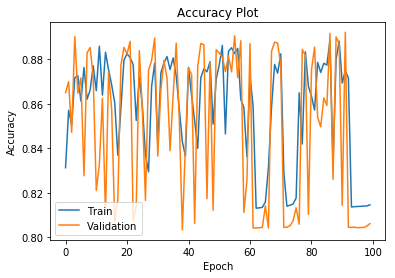

In [46]:
plt.plot(model1_history.history['acc'])
plt.plot(model1_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

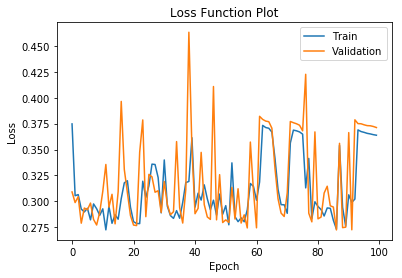

In [47]:
plt.plot(model1_history.history['loss'])
plt.plot(model1_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [48]:
train_model1_pred = mlp_model1.predict_classes(X_train)
test_model1_pred = mlp_model1.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [49]:
confusion_matrix_train = confusion_matrix(y_train, train_model1_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model1_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32951   101]
 [ 7504   174]]
[[14098    67]
 [ 3213    78]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [50]:
Accuracy_Train_M1 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M1 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M1 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M1)
print("Train TPR: ",TPR_Train_M1)
print("Train Accuracy: ",Accuracy_Train_M1)

print("-----------------------")

Accuracy_Test_M1 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M1)
print("Test TPR: ",TPR_Test_M1)
print("Test Accuracy: ",Accuracy_Test_M1)

Train TNR:  0.9969442091250151
Train TPR:  0.022662151601979683
Train Accuracy:  0.8132825926835257
-----------------------
Test TNR:  0.9952700317684433
Test TPR:  0.023701002734731084
Test Accuracy:  0.8120989917506874


### MLP with 2 layers

    1 hidden layer with 20 neurons

In [51]:
np.random.seed(123)

tf.set_random_seed(123)

In [52]:
mlp_model2 = Sequential()

mlp_model2.add(Dense(20, input_dim=21, activation='sigmoid', kernel_initializer='normal'))
mlp_model2.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [53]:
mlp_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                440       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [54]:
mlp_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [55]:
model2_history = mlp_model2.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.4053 - acc: 0.8128 - val_loss: 0.3543 - val_acc: 0.8191
Epoch 2/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.3277 - acc: 0.8394 - val_loss: 0.3112 - val_acc: 0.8583
Epoch 3/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.3051 - acc: 0.8559 - val_loss: 0.3231 - val_acc: 0.8078
Epoch 4/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2997 - acc: 0.8673 - val_loss: 0.3073 - val_acc: 0.8472
Epoch 5/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2848 - acc: 0.8806 - val_loss: 0.2773 - val_acc: 0.8814
Epoch 6/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2738 - acc: 0.8869 - val_loss: 0.2774 - val_acc: 0.8823
Epoch 7/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2698 - acc: 0.8903 - val_loss: 0.2727 - v

32584/32584 [==============================] - 1s 19us/step - loss: 0.2718 - acc: 0.8863 - val_loss: 0.2712 - val_acc: 0.8885
Epoch 60/100
32584/32584 [==============================] - 1s 20us/step - loss: 0.2664 - acc: 0.8887 - val_loss: 0.3054 - val_acc: 0.8469
Epoch 61/100
32584/32584 [==============================] - 1s 20us/step - loss: 0.2635 - acc: 0.8913 - val_loss: 0.2598 - val_acc: 0.8899
Epoch 62/100
32584/32584 [==============================] - 1s 19us/step - loss: 0.2562 - acc: 0.8958 - val_loss: 0.2599 - val_acc: 0.8896
Epoch 63/100
32584/32584 [==============================] - 1s 19us/step - loss: 0.2534 - acc: 0.8953 - val_loss: 0.2670 - val_acc: 0.8888
Epoch 64/100
32584/32584 [==============================] - 1s 20us/step - loss: 0.2682 - acc: 0.8869 - val_loss: 0.2816 - val_acc: 0.8791
Epoch 65/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2693 - acc: 0.8786 - val_loss: 0.2617 - val_acc: 0.8840
Epoch 66/100
32584/32584 [==============

##### Plot

In [56]:
print(model2_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


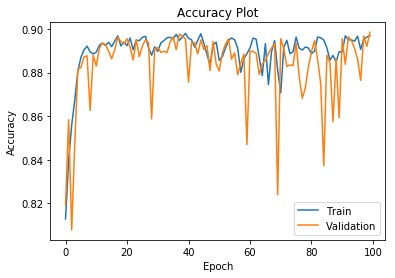

In [57]:
plt.plot(model2_history.history['acc'])
plt.plot(model2_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

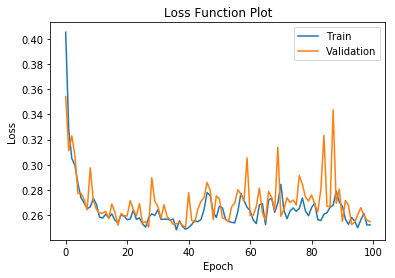

In [58]:
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [59]:
train_model2_pred = mlp_model2.predict_classes(X_train)
test_model2_pred = mlp_model2.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [60]:
confusion_matrix_train = confusion_matrix(y_train, train_model2_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model2_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31322  1730]
 [ 2293  5385]]
[[13375   790]
 [ 1043  2248]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [61]:
Accuracy_Train_M2 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M2 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M2 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M2)
print("Train TPR: ",TPR_Train_M2)
print("Train Accuracy: ",Accuracy_Train_M2)

print("-----------------------")

Accuracy_Test_M2 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M2 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M2 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M2)
print("Test TPR: ",TPR_Test_M2)
print("Test Accuracy: ",Accuracy_Test_M2)

Train TNR:  0.9476582355076849
Train TPR:  0.7013545194060954
Train Accuracy:  0.9012275963663148
-----------------------
Test TNR:  0.9442287327920932
Test TPR:  0.6830750531753267
Test Accuracy:  0.8949931255728689


### MLP with 2 layers

    1 hidden layer with 25 neurons

In [62]:
np.random.seed(123)

tf.set_random_seed(123)

In [63]:
mlp_model3 = Sequential()

mlp_model3.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model3.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [64]:
mlp_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 25)                550       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [65]:
mlp_model3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [66]:
model3_history = mlp_model3.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.3412 - acc: 0.8523 - val_loss: 0.2995 - val_acc: 0.8619
Epoch 2/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2873 - acc: 0.8740 - val_loss: 0.2845 - val_acc: 0.8717
Epoch 3/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2847 - acc: 0.8727 - val_loss: 0.2853 - val_acc: 0.8820
Epoch 4/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.2764 - acc: 0.8816 - val_loss: 0.2759 - val_acc: 0.8830
Epoch 5/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2696 - acc: 0.8881 - val_loss: 0.2978 - val_acc: 0.8809
Epoch 6/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.2758 - acc: 0.8818 - val_loss: 0.2699 - val_acc: 0.8850
Epoch 7/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2684 - acc: 0.8824 - val_loss: 0.2845 - v

32584/32584 [==============================] - 1s 21us/step - loss: 0.3373 - acc: 0.8299 - val_loss: 0.3533 - val_acc: 0.8303
Epoch 60/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.3192 - acc: 0.8609 - val_loss: 0.3180 - val_acc: 0.8621
Epoch 61/100
32584/32584 [==============================] - 1s 23us/step - loss: 0.2968 - acc: 0.8746 - val_loss: 0.2868 - val_acc: 0.8797
Epoch 62/100
32584/32584 [==============================] - ETA: 0s - loss: 0.2897 - acc: 0.878 - 1s 23us/step - loss: 0.2882 - acc: 0.8787 - val_loss: 0.2843 - val_acc: 0.8788
Epoch 63/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.2859 - acc: 0.8742 - val_loss: 0.3326 - val_acc: 0.8233
Epoch 64/100
32584/32584 [==============================] - 1s 34us/step - loss: 0.3383 - acc: 0.8357 - val_loss: 0.3641 - val_acc: 0.8070
Epoch 65/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.3434 - acc: 0.8187 - val_loss: 0.3331 - val_acc: 0.8151
Ep

##### Plot

In [67]:
print(model3_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


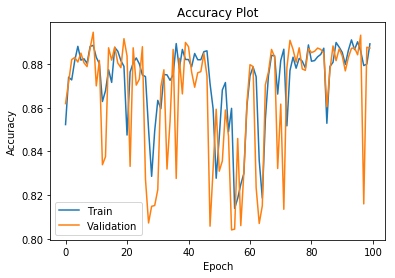

In [68]:
plt.plot(model3_history.history['acc'])
plt.plot(model3_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

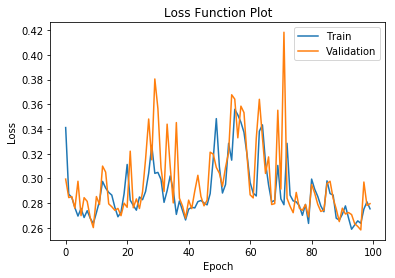

In [69]:
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [70]:
train_model3_pred = mlp_model3.predict_classes(X_train)
test_model3_pred = mlp_model3.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [71]:
confusion_matrix_train = confusion_matrix(y_train, train_model3_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model3_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30927  2125]
 [ 2195  5483]]
[[13231   934]
 [  960  2331]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [72]:
Accuracy_Train_M3 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M3 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M3 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M3)
print("Train TPR: ",TPR_Train_M3)
print("Train Accuracy: ",Accuracy_Train_M3)

print("-----------------------")

Accuracy_Test_M3 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M3 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M3 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M3)
print("Test TPR: ",TPR_Test_M3)
print("Test Accuracy: ",Accuracy_Test_M3)

Train TNR:  0.9357073702045262
Train TPR:  0.7141182599635322
Train Accuracy:  0.8939356739504051
-----------------------
Test TNR:  0.9340628309212848
Test TPR:  0.7082953509571559
Test Accuracy:  0.8914986251145738


Observation:

    Based on the TPR, 2 layer MLP with 25 nodes hidden layer is best

### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 15 neurons

In [73]:
np.random.seed(123)

tf.set_random_seed(123)

In [74]:
mlp_model4 = Sequential()

mlp_model4.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(15, activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [75]:
mlp_model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 25)                550       
_________________________________________________________________
dense_9 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [76]:
mlp_model4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [77]:
model4_history = mlp_model4.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/150
32584/32584 [==============================] - 1s 41us/step - loss: 0.4589 - acc: 0.8159 - val_loss: 0.3305 - val_acc: 0.8565
Epoch 2/150
32584/32584 [==============================] - 1s 27us/step - loss: 0.2931 - acc: 0.8780 - val_loss: 0.2798 - val_acc: 0.8830
Epoch 3/150
32584/32584 [==============================] - 1s 27us/step - loss: 0.2828 - acc: 0.8792 - val_loss: 0.3005 - val_acc: 0.8397
Epoch 4/150
32584/32584 [==============================] - 1s 27us/step - loss: 0.2815 - acc: 0.8778 - val_loss: 0.3041 - val_acc: 0.8424
Epoch 5/150
32584/32584 [==============================] - 1s 28us/step - loss: 0.2833 - acc: 0.8785 - val_loss: 0.2707 - val_acc: 0.8872
Epoch 6/150
32584/32584 [==============================] - 1s 27us/step - loss: 0.2793 - acc: 0.8802 - val_loss: 0.3013 - val_acc: 0.8554
Epoch 7/150
32584/32584 [==============================] - 1s 27us/step - loss: 0.2910 - acc: 0.8721 - val_loss: 0.3135 - v

32584/32584 [==============================] - 1s 29us/step - loss: 0.3114 - acc: 0.8618 - val_loss: 0.2890 - val_acc: 0.8737
Epoch 60/150
32584/32584 [==============================] - 1s 29us/step - loss: 0.3247 - acc: 0.8473 - val_loss: 0.3778 - val_acc: 0.8054
Epoch 61/150
32584/32584 [==============================] - 1s 31us/step - loss: 0.3495 - acc: 0.8213 - val_loss: 0.3456 - val_acc: 0.8209
Epoch 62/150
32584/32584 [==============================] - 1s 30us/step - loss: 0.3075 - acc: 0.8555 - val_loss: 0.3180 - val_acc: 0.8497
Epoch 63/150
32584/32584 [==============================] - 1s 29us/step - loss: 0.3022 - acc: 0.8562 - val_loss: 0.2815 - val_acc: 0.8755
Epoch 64/150
32584/32584 [==============================] - 1s 34us/step - loss: 0.2901 - acc: 0.8715 - val_loss: 0.2801 - val_acc: 0.8830 0s - loss: 0.2935 - acc: 
Epoch 65/150
32584/32584 [==============================] - 1s 42us/step - loss: 0.2799 - acc: 0.8833 - val_loss: 0.2780 - val_acc: 0.8752
Epoch 66/150
3

32584/32584 [==============================] - 1s 38us/step - loss: 0.2715 - acc: 0.8910 - val_loss: 0.2689 - val_acc: 0.8917
Epoch 118/150
32584/32584 [==============================] - 1s 36us/step - loss: 0.2885 - acc: 0.8809 - val_loss: 0.2668 - val_acc: 0.8960
Epoch 119/150
32584/32584 [==============================] - 1s 31us/step - loss: 0.2796 - acc: 0.8847 - val_loss: 0.2705 - val_acc: 0.8971
Epoch 120/150
32584/32584 [==============================] - 1s 36us/step - loss: 0.2648 - acc: 0.8955 - val_loss: 0.2645 - val_acc: 0.8966
Epoch 121/150
32584/32584 [==============================] - 1s 31us/step - loss: 0.2640 - acc: 0.8977 - val_loss: 0.2719 - val_acc: 0.8867
Epoch 122/150
32584/32584 [==============================] - 1s 36us/step - loss: 0.2850 - acc: 0.8809 - val_loss: 0.3582 - val_acc: 0.8139
Epoch 123/150
32584/32584 [==============================] - 1s 26us/step - loss: 0.3320 - acc: 0.8401 - val_loss: 0.2715 - val_acc: 0.8878
Epoch 124/150
32584/32584 [=======

##### Plot

In [78]:
print(model4_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


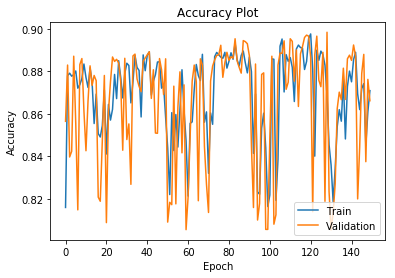

In [79]:
plt.plot(model4_history.history['acc'])
plt.plot(model4_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

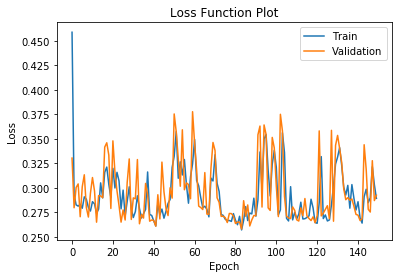

In [80]:
plt.plot(model4_history.history['loss'])
plt.plot(model4_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [81]:
train_model4_pred = mlp_model4.predict_classes(X_train)
test_model4_pred = mlp_model4.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [82]:
confusion_matrix_train = confusion_matrix(y_train, train_model4_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model4_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30545  2507]
 [ 2880  4798]]
[[13083  1082]
 [ 1259  2032]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [83]:
Accuracy_Train_M4 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M4 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M4 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M4)
print("Train TPR: ",TPR_Train_M4)
print("Train Accuracy: ",Accuracy_Train_M4)

print("-----------------------")

Accuracy_Test_M4 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M4 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M4 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M4)
print("Test TPR: ",TPR_Test_M4)
print("Test Accuracy: ",Accuracy_Test_M4)

Train TNR:  0.9241498245189399
Train TPR:  0.6249023183120604
Train Accuracy:  0.8677387674932482
-----------------------
Test TNR:  0.9236145428873985
Test TPR:  0.6174415071406867
Test Accuracy:  0.865891384051329


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons

In [84]:
np.random.seed(123)

tf.set_random_seed(123)

In [85]:
mlp_model5 = Sequential()

mlp_model5.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model5.add(Dense(20, activation='tanh', kernel_initializer='normal'))
mlp_model5.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [86]:
mlp_model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_12 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
_________________________________________________________________


In [87]:
mlp_model5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [88]:
model5_history = mlp_model5.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 39us/step - loss: 0.4102 - acc: 0.8371 - val_loss: 0.3178 - val_acc: 0.8540
Epoch 2/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2897 - acc: 0.8742 - val_loss: 0.2824 - val_acc: 0.8818
Epoch 3/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.2785 - acc: 0.8811 - val_loss: 0.2911 - val_acc: 0.8718
Epoch 4/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.2802 - acc: 0.8800 - val_loss: 0.2795 - val_acc: 0.8829
Epoch 5/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.2842 - acc: 0.8747 - val_loss: 0.2793 - val_acc: 0.8893
Epoch 6/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.2756 - acc: 0.8830 - val_loss: 0.2820 - val_acc: 0.8711
Epoch 7/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.2700 - acc: 0.8861 - val_loss: 0.2763 - v

32584/32584 [==============================] - 1s 24us/step - loss: 0.2707 - acc: 0.8867 - val_loss: 0.2721 - val_acc: 0.8851
Epoch 60/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.3049 - acc: 0.8664 - val_loss: 0.2798 - val_acc: 0.8850
Epoch 61/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2764 - acc: 0.8845 - val_loss: 0.2779 - val_acc: 0.8814
Epoch 62/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.3281 - acc: 0.8540 - val_loss: 0.2919 - val_acc: 0.8734
Epoch 63/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.3152 - acc: 0.8525 - val_loss: 0.2893 - val_acc: 0.8725
Epoch 64/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.2843 - acc: 0.8767 - val_loss: 0.2746 - val_acc: 0.8879
Epoch 65/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.3007 - acc: 0.8701 - val_loss: 0.2848 - val_acc: 0.8820
Epoch 66/100
32584/32584 [==============

##### Plot

In [89]:
print(model5_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


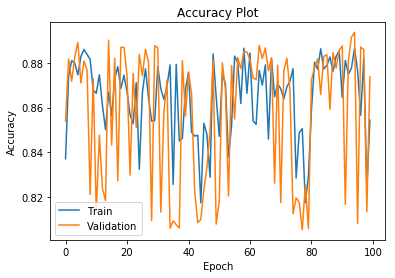

In [90]:
plt.plot(model5_history.history['acc'])
plt.plot(model5_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

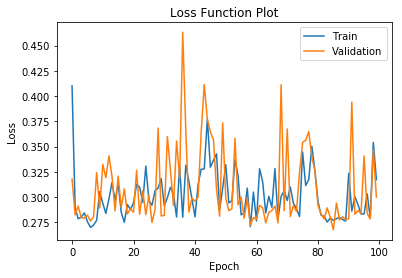

In [91]:
plt.plot(model5_history.history['loss'])
plt.plot(model5_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [92]:
train_model5_pred = mlp_model5.predict_classes(X_train)
test_model5_pred = mlp_model5.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [93]:
confusion_matrix_train = confusion_matrix(y_train, train_model5_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model5_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30073  2979]
 [ 1912  5766]]
[[12828  1337]
 [  849  2442]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [94]:
Accuracy_Train_M5 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M5 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M5 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M5)
print("Train TPR: ",TPR_Train_M5)
print("Train Accuracy: ",Accuracy_Train_M5)
print("-----------------------")

Accuracy_Test_M5 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M5 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M5 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M5)
print("Test TPR: ",TPR_Test_M5)
print("Test Accuracy: ",Accuracy_Test_M5)

Train TNR:  0.9098692968655452
Train TPR:  0.7509768168793957
Train Accuracy:  0.8799165234470906
-----------------------
Test TNR:  0.9056124249911754
Test TPR:  0.7420237010027347
Test Accuracy:  0.8747708524289642


Observation:

    Based on the TPR: 2 layer mlp, with 25 nodes in hiddent layer

### MLP with 4 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons
    3nd hidden layer with 15 neurons

In [95]:
np.random.seed(123)

tf.set_random_seed(123)

In [96]:
mlp_model6 = Sequential()

mlp_model6.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model6.add(Dense(20, activation='tanh', kernel_initializer='normal'))
mlp_model6.add(Dense(15, activation='tanh', kernel_initializer='normal'))
mlp_model6.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [97]:
mlp_model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_16 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 16        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [98]:
mlp_model6.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [99]:
model6_history = mlp_model6.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 50us/step - loss: 0.5469 - acc: 0.8123 - val_loss: 0.4635 - val_acc: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.3669 - acc: 0.8338 - val_loss: 0.3118 - val_acc: 0.8731
Epoch 3/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.2863 - acc: 0.8798 - val_loss: 0.3064 - val_acc: 0.8405
Epoch 4/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.2911 - acc: 0.8717 - val_loss: 0.3033 - val_acc: 0.8576
Epoch 5/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.2814 - acc: 0.8779 - val_loss: 0.2663 - val_acc: 0.8866
Epoch 6/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.2861 - acc: 0.8722 - val_loss: 0.3017 - val_acc: 0.8807
Epoch 7/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.2867 - acc: 0.8753 - val_loss: 0.2675 - v

32584/32584 [==============================] - 1s 37us/step - loss: 0.3608 - acc: 0.8142 - val_loss: 0.3659 - val_acc: 0.8097
Epoch 60/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.3527 - acc: 0.8162 - val_loss: 0.3563 - val_acc: 0.8064
Epoch 61/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.3618 - acc: 0.8226 - val_loss: 0.3940 - val_acc: 0.8071
Epoch 62/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.3738 - acc: 0.8215 - val_loss: 0.3663 - val_acc: 0.8275
Epoch 63/100
32584/32584 [==============================] - 1s 38us/step - loss: 0.3494 - acc: 0.8368 - val_loss: 0.3813 - val_acc: 0.8128
Epoch 64/100
32584/32584 [==============================] - 1s 39us/step - loss: 0.3439 - acc: 0.8321 - val_loss: 0.3191 - val_acc: 0.8264
Epoch 65/100
32584/32584 [==============================] - 1s 35us/step - loss: 0.3023 - acc: 0.8643 - val_loss: 0.3605 - val_acc: 0.8051
Epoch 66/100
32584/32584 [==============

##### Plot

In [100]:
print(model6_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


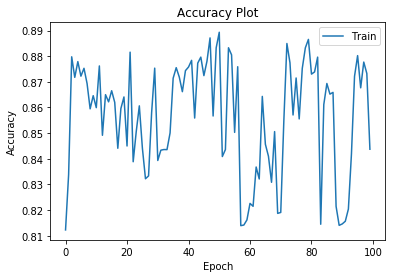

In [101]:
plt.plot(model6_history.history['acc'])
# plt.plot(model4_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

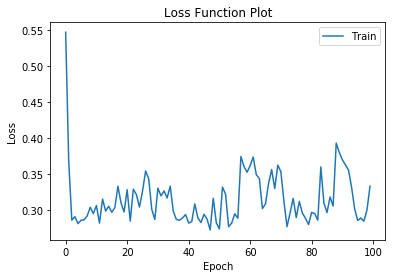

In [102]:
plt.plot(model6_history.history['loss'])
# plt.plot(model4_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [103]:
train_model6_pred = mlp_model6.predict_classes(X_train)
test_model6_pred = mlp_model6.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [104]:
confusion_matrix_train = confusion_matrix(y_train, train_model6_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model6_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32893   159]
 [ 7496   182]]
[[14077    88]
 [ 3204    87]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [105]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9951893985235387
Train TPR:  0.023704089606668404
Train Accuracy:  0.8120549963172109
-----------------------
Test TNR:  0.9937875044122838
Test TPR:  0.02643573381950775
Test Accuracy:  0.8114115490375802


Observation:

    With respect to TPR, 2 layer mlp with 25 nodes in hidden layer is best 

## Find best parameter

#### Function for creation of model

In [106]:
def model_def(h_activation, o_activation, kernel_init):
    
    model=Sequential()
    
    model.add(Dense(25, input_dim=21, activation=h_activation, kernel_initializer=kernel_init))
    model.add(Dense(15, activation=h_activation, kernel_initializer=kernel_init))
    model.add(Dense(1, activation=o_activation, kernel_initializer=kernel_init))
    
    return model 

#### Store the best parameters

In [107]:
best_params={}

### Find the best Learning rate

    Using logarithmic scale randomly generate values between 0.0001 to 1 

In [108]:
NUM_LR = 10 

lrs = [round(i, 4) for i in list(10 ** (-4 * np.random.rand(NUM_LR)))]

lrs

[0.2703, 0.0144, 0.0214, 0.0003, 0.0002, 0.0008, 0.1425, 0.0049, 0.022, 0.1388]

In [115]:
(10 ** (-4 * np.random.rand(NUM_LR)))

array([1.48348930e-04, 2.19913750e-03, 2.80148929e-01, 8.50036060e-04,
       2.41232332e-03, 1.43393446e-04, 3.07005024e-02, 2.41882240e-02,
       1.20440577e-02, 2.12707616e-04])

In [116]:
hist_loss = []

for lr in lrs:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    lr_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')
    
    # Compile model
    sgd = optimizers.SGD(lr=lr)
    
    lr_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
    lr_model_history = lr_model.fit(X_train, y_train, validation_split=0.2, epochs=1, 
                                    shuffle=True, steps_per_epoch=50, validation_steps=50)
    
    hist_loss.append(lr_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 5s 105ms/step - loss: 0.3829 - acc: 0.8250 - val_loss: 0.3052 - val_acc: 0.8529
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 5s 104ms/step - loss: 0.6486 - acc: 0.7676 - val_loss: 0.6057 - val_acc: 0.8048
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 5s 107ms/step - loss: 0.6279 - acc: 0.7809 - val_loss: 0.5686 - val_acc: 0.8048
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 6s 115ms/step - loss: 0.6993 - acc: 0.3944 - val_loss: 0.6984 - val_acc: 0.4160
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 6s 119ms/step - loss: 0.6998 - acc: 0.3843 - val_loss: 0.6992 - val_acc: 0.3979
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 

In [117]:
# Get the lr and loss Dataframe
loss_lr = pd.DataFrame([lrs,hist_loss]).T  

#Give the coloumn names
loss_lr.columns=['lr', 'loss']

#Sort the values and reset the index
loss_lr=loss_lr.sort_values('loss').reset_index().drop('index',axis=1)
loss_lr

,lr,loss
0,0.2703,[0.38292531728744506]
1,0.1425,[0.42358253061771395]
2,0.1388,[0.4282323896884918]
3,0.022,[0.6261806499958038]
4,0.0214,[0.627885103225708]
5,0.0144,[0.6486277496814727]
6,0.0049,[0.6805653750896454]
7,0.0008,[0.6971755254268647]
8,0.0003,[0.6993396198749542]
9,0.0002,[0.6997769260406494]


In [118]:
#pick the top lr
best_params['best_learning_rate'] = loss_lr.loc[:,'lr'][0]

#### Build model with the best learning rate

#### Got the below value as best learning rate after different experiments

In [119]:
np.random.seed(123)
tf.set_random_seed(123)

In [120]:
bst_lr_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')

In [121]:
bst_lr_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_49 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [122]:
sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
bst_lr_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [123]:
bst_lr_model_history = bst_lr_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 54us/step - loss: 0.3494 - acc: 0.8231 - val_loss: 0.3217 - val_acc: 0.8491
Epoch 2/100
32584/32584 [==============================] - 1s 35us/step - loss: 0.3422 - acc: 0.8237 - val_loss: 0.3486 - val_acc: 0.8507
Epoch 3/100
32584/32584 [==============================] - 1s 34us/step - loss: 0.3447 - acc: 0.8313 - val_loss: 0.4735 - val_acc: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.3570 - acc: 0.8201 - val_loss: 0.3639 - val_acc: 0.8082
Epoch 5/100
32584/32584 [==============================] - 1s 36us/step - loss: 0.3461 - acc: 0.8210 - val_loss: 0.3065 - val_acc: 0.8591
Epoch 6/100
32584/32584 [==============================] - 1s 31us/step - loss: 0.3651 - acc: 0.8209 - val_loss: 0.3197 - val_acc: 0.8384
Epoch 7/100
32584/32584 [==============================] - 1s 36us/step - loss: 0.3354 - acc: 0.8330 - val_loss: 0.3327 - v

32584/32584 [==============================] - 1s 37us/step - loss: 0.2992 - acc: 0.8647 - val_loss: 0.2954 - val_acc: 0.8601
Epoch 60/100
32584/32584 [==============================] - 1s 43us/step - loss: 0.3271 - acc: 0.8372 - val_loss: 0.3850 - val_acc: 0.8065
Epoch 61/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3602 - acc: 0.8147 - val_loss: 0.3754 - val_acc: 0.8068
Epoch 62/100
32584/32584 [==============================] - 1s 30us/step - loss: 0.3542 - acc: 0.8143 - val_loss: 0.3658 - val_acc: 0.8071
Epoch 63/100
32584/32584 [==============================] - 1s 29us/step - loss: 0.3514 - acc: 0.8141 - val_loss: 0.3794 - val_acc: 0.8069
Epoch 64/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3408 - acc: 0.8164 - val_loss: 0.3497 - val_acc: 0.8073
Epoch 65/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3228 - acc: 0.8331 - val_loss: 0.3406 - val_acc: 0.8173
Epoch 66/100
32584/32584 [==============

##### Plot

In [124]:
print(bst_lr_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


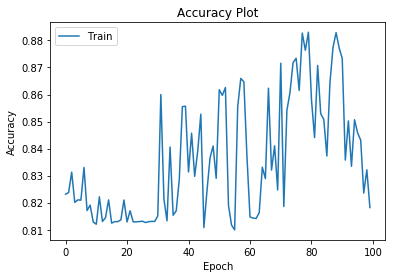

In [125]:
plt.plot(bst_lr_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

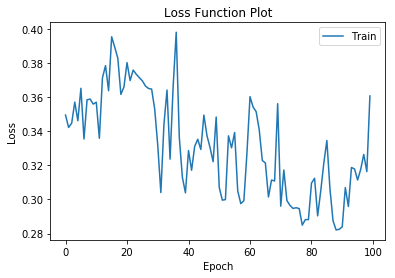

In [126]:
plt.plot(bst_lr_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [127]:
train_bst_lr_model_pred = bst_lr_model.predict_classes(X_train)
test_bst_lr_model_pred = bst_lr_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [128]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_lr_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_lr_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32947   105]
 [ 7456   222]]
[[14108    57]
 [ 3195    96]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [129]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9968231877042236
Train TPR:  0.02891377963011201
Train Accuracy:  0.8143628774858827
-----------------------
Test TNR:  0.9959759971761384
Test TPR:  0.02917046490428441
Test Accuracy:  0.8137030247479377


#### Find the best Batch size 

In [130]:
batch_sizes = [32, 64, 128, 256]

In [131]:
history=[]

for batch_size in batch_sizes:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    bs_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')
    
     # Compile model
    sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
    bs_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    #Fit the model
    bs_model_history = bs_model.fit(X_train, y_train, batch_size=batch_size, epochs=10,
                                    validation_split=0.2, shuffle=True)
    
    history.append(bs_model_history)

Train on 32584 samples, validate on 8146 samples
Epoch 1/10
32584/32584 [==============================] - 3s 80us/step - loss: 0.3473 - acc: 0.8214 - val_loss: 0.3454 - val_acc: 0.7973
Epoch 2/10
32584/32584 [==============================] - 2s 54us/step - loss: 0.3275 - acc: 0.8363 - val_loss: 0.3370 - val_acc: 0.7812
Epoch 3/10
32584/32584 [==============================] - 2s 53us/step - loss: 0.3441 - acc: 0.8154 - val_loss: 0.4001 - val_acc: 0.8044
Epoch 4/10
32584/32584 [==============================] - 2s 58us/step - loss: 0.3374 - acc: 0.8202 - val_loss: 0.3613 - val_acc: 0.8044
Epoch 5/10
32584/32584 [==============================] - 2s 60us/step - loss: 0.3428 - acc: 0.8200 - val_loss: 0.3542 - val_acc: 0.8121
Epoch 6/10
32584/32584 [==============================] - 2s 64us/step - loss: 0.3271 - acc: 0.8265 - val_loss: 0.3286 - val_acc: 0.8016
Epoch 7/10
32584/32584 [==============================] - 2s 57us/step - loss: 0.3303 - acc: 0.8250 - val_loss: 0.2946 - val_acc:

###### Summarize history for train loss

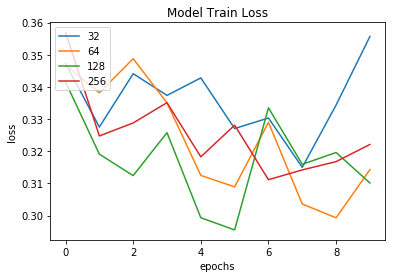

In [132]:
for i in range(0, len(history)):
    plt.plot(history[i].history['loss'])
plt.title('Model Train Loss')
plt.ylabel('loss')
plt.xlabel('epochs')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

###### Summarize history for test loss

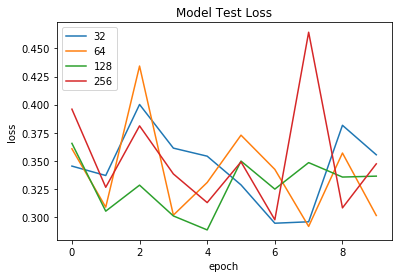

In [133]:
for i in range(0, len(history)):
    plt.plot(history[i].history['val_loss'])
plt.title('Model Test Loss')
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

#### Build model with the best batch size

In [134]:
best_params['best_batch_size'] = 256

In [135]:
np.random.seed(123)
tf.set_random_seed(123)
    
bst_bs_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')

In [136]:
sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
bst_bs_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [137]:
bst_bs_model_history = bst_bs_model.fit(X_train, y_train, epochs=100, 
                                        batch_size=best_params['best_batch_size'],
                                        validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 47us/step - loss: 0.3578 - acc: 0.8238 - val_loss: 0.3770 - val_acc: 0.8195
Epoch 2/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3200 - acc: 0.8458 - val_loss: 0.3340 - val_acc: 0.8187
Epoch 3/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3270 - acc: 0.8331 - val_loss: 0.4116 - val_acc: 0.8049
Epoch 4/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.3367 - acc: 0.8354 - val_loss: 0.3230 - val_acc: 0.8691
Epoch 5/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.3171 - acc: 0.8499 - val_loss: 0.3253 - val_acc: 0.8570
Epoch 6/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3210 - acc: 0.8491 - val_loss: 0.3617 - val_acc: 0.8559
Epoch 7/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3223 - acc: 0.8386 - val_loss: 0.3665 - v

32584/32584 [==============================] - 0s 15us/step - loss: 0.2885 - acc: 0.8758 - val_loss: 0.3039 - val_acc: 0.8442
Epoch 60/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3379 - acc: 0.8482 - val_loss: 0.2934 - val_acc: 0.8829
Epoch 61/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3002 - acc: 0.8539 - val_loss: 0.2889 - val_acc: 0.8826
Epoch 62/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3313 - acc: 0.8468 - val_loss: 0.3847 - val_acc: 0.8043
Epoch 63/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3732 - acc: 0.8140 - val_loss: 0.3789 - val_acc: 0.8058
Epoch 64/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3712 - acc: 0.8140 - val_loss: 0.3750 - val_acc: 0.8062
Epoch 65/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3496 - acc: 0.8195 - val_loss: 0.3861 - val_acc: 0.8054
Epoch 66/100
32584/32584 [==============

##### Plot

In [138]:
print(bst_bs_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


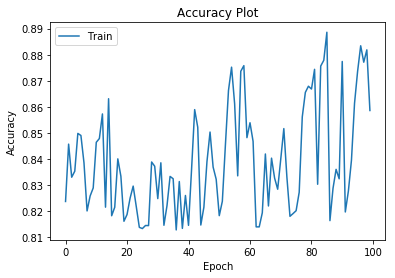

In [139]:
plt.plot(bst_bs_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

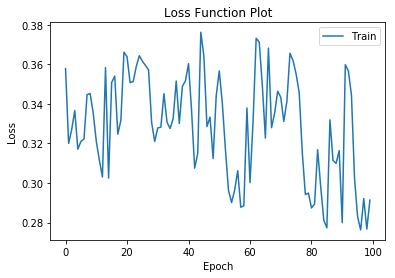

In [140]:
plt.plot(bst_bs_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [141]:
train_bst_bs_model_pred = bst_bs_model.predict_classes(X_train)
test_bst_bs_model_pred = bst_bs_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [142]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_bs_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_bs_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31028  2024]
 [ 2820  4858]]
[[13296   869]
 [ 1241  2050]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [143]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9387631610795111
Train TPR:  0.6327168533472258
Train Accuracy:  0.8810704640314264
-----------------------
Test TNR:  0.9386516060713025
Test TPR:  0.62291096931024
Test Accuracy:  0.8791246562786434


#### Model with Relu as activation in hidden layer,Adam optimizer,Modified Xavier

In [144]:
np.random.seed(123)
tf.set_random_seed(123)

In [145]:
relu_model= model_def(h_activation='relu',o_activation='sigmoid',kernel_init='glorot_normal')

In [146]:
relu_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [147]:
relu_model_history = relu_model.fit(X_train, y_train, epochs=100,
                                    batch_size=best_params['best_batch_size'],
                                    validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 51us/step - loss: 0.5575 - acc: 0.8550 - val_loss: 0.3899 - val_acc: 0.8804
Epoch 2/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3950 - acc: 0.8868 - val_loss: 0.6357 - val_acc: 0.8531
Epoch 3/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.3716 - acc: 0.8895 - val_loss: 0.3846 - val_acc: 0.8809
Epoch 4/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.6694 - acc: 0.8664 - val_loss: 1.3284 - val_acc: 0.8206
Epoch 5/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.8395 - acc: 0.8493 - val_loss: 0.4004 - val_acc: 0.8867
Epoch 6/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.4203 - acc: 0.8873 - val_loss: 0.3745 - val_acc: 0.8938
Epoch 7/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.4021 - acc: 0.8930 - val_loss: 0.3592 - v

32584/32584 [==============================] - 1s 16us/step - loss: 0.2656 - acc: 0.9057 - val_loss: 0.2882 - val_acc: 0.8969
Epoch 60/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2758 - acc: 0.9031 - val_loss: 0.2809 - val_acc: 0.8996
Epoch 61/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2708 - acc: 0.9047 - val_loss: 0.2816 - val_acc: 0.9015
Epoch 62/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2674 - acc: 0.9041 - val_loss: 0.2897 - val_acc: 0.8988
Epoch 63/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2667 - acc: 0.9031 - val_loss: 0.2803 - val_acc: 0.9002
Epoch 64/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2592 - acc: 0.9055 - val_loss: 0.2774 - val_acc: 0.9013
Epoch 65/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2668 - acc: 0.9042 - val_loss: 0.2712 - val_acc: 0.9006
Epoch 66/100
32584/32584 [==============

##### Plot

In [148]:
print(relu_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


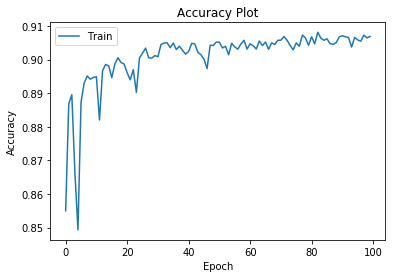

In [149]:
plt.plot(relu_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

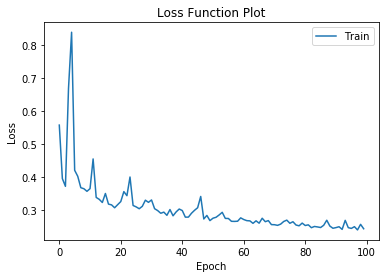

In [150]:
plt.plot(relu_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [151]:
train_relu_model_pred = relu_model.predict_classes(X_train)
test_relu_model_pred = relu_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [152]:
confusion_matrix_train = confusion_matrix(y_train, train_relu_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_relu_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31270  1782]
 [ 2041  5637]]
[[13339   826]
 [  915  2376]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [153]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9460849570373956
Train TPR:  0.73417556655379
Train Accuracy:  0.9061379818315738
-----------------------
Test TNR:  0.9416872573243911
Test TPR:  0.7219690063810392
Test Accuracy:  0.9002635197066912


In [154]:
best_params['best_h_activation']='relu'
best_params['best_kernel_init']='glorot_normal'
best_params['best_optimizer']='adam'

#### Model with Dropout

In [155]:
np.random.seed(123)
tf.set_random_seed(123)

In [156]:
dropout_model = Sequential()
dropout_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [157]:
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [158]:
dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [159]:
dropout_model_history = dropout_model.fit(X_train, y_train, epochs=100,
                                          batch_size=best_params['best_batch_size'], 
                                          validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 62us/step - loss: 1.9275 - acc: 0.7270 - val_loss: 0.6349 - val_acc: 0.8162
Epoch 2/100
32584/32584 [==============================] - 1s 23us/step - loss: 1.0410 - acc: 0.8017 - val_loss: 0.4337 - val_acc: 0.8119
Epoch 3/100
32584/32584 [==============================] - 1s 19us/step - loss: 0.7148 - acc: 0.8104 - val_loss: 0.4058 - val_acc: 0.8101
Epoch 4/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.5799 - acc: 0.8144 - val_loss: 0.3835 - val_acc: 0.8062
Epoch 5/100
32584/32584 [==============================] - 1s 19us/step - loss: 0.5239 - acc: 0.8138 - val_loss: 0.3714 - val_acc: 0.8052
Epoch 6/100
32584/32584 [==============================] - 1s 18us/step - loss: 0.4822 - acc: 0.8129 - val_loss: 0.3661 - val_acc: 0.8047
Epoch 7/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.4594 - acc: 0.8134 - val_loss: 0.3609 - v

32584/32584 [==============================] - 1s 21us/step - loss: 0.2944 - acc: 0.8862 - val_loss: 0.2691 - val_acc: 0.8926
Epoch 60/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2946 - acc: 0.8852 - val_loss: 0.2667 - val_acc: 0.8958
Epoch 61/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2929 - acc: 0.8858 - val_loss: 0.2686 - val_acc: 0.8922
Epoch 62/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2925 - acc: 0.8866 - val_loss: 0.2677 - val_acc: 0.8938
Epoch 63/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2914 - acc: 0.8849 - val_loss: 0.2683 - val_acc: 0.8932
Epoch 64/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2886 - acc: 0.8881 - val_loss: 0.2663 - val_acc: 0.8941
Epoch 65/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2941 - acc: 0.8859 - val_loss: 0.2655 - val_acc: 0.8941
Epoch 66/100
32584/32584 [==============

##### Plot

In [160]:
print(dropout_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


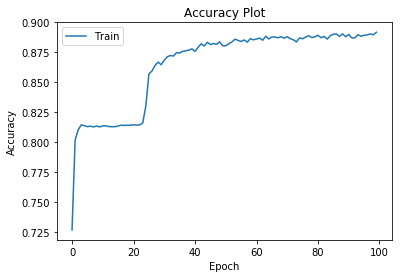

In [161]:
plt.plot(dropout_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

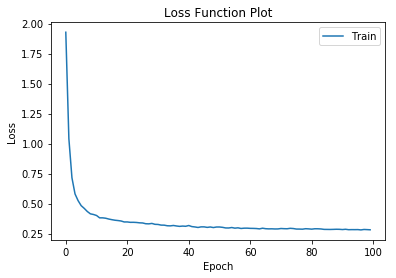

In [162]:
plt.plot(dropout_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [163]:
train_dropout_model_pred = dropout_model.predict_classes(X_train)
test_dropout_model_pred = dropout_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [164]:
confusion_matrix_train = confusion_matrix(y_train, train_dropout_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_dropout_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30760  2292]
 [ 1773  5905]]
[[13152  1013]
 [  803  2488]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [165]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9306547258864819
Train TPR:  0.7690804897108622
Train Accuracy:  0.9001964154186104
-----------------------
Test TNR:  0.9284857042004941
Test TPR:  0.7560012154360377
Test Accuracy:  0.8959670027497708


#### Model with Batch Normalization

In [166]:
np.random.seed(123)
tf.set_random_seed(123)

In [167]:
bn_model = Sequential()
bn_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [168]:
bn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 25)                550       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_73 (Dense)             (None, 15)                390       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 16        
Total params: 1,116
Trainable params: 1,036
Non-trainable params: 80
_________________________________________________________________


In [169]:
bn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [170]:
bn_model_history = bn_model.fit(X_train, y_train, epochs=100,
                                batch_size=best_params['best_batch_size'], 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 75us/step - loss: 0.6067 - acc: 0.7542 - val_loss: 0.7490 - val_acc: 0.2309
Epoch 2/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.4374 - acc: 0.8343 - val_loss: 0.6817 - val_acc: 0.4135
Epoch 3/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.3597 - acc: 0.8500 - val_loss: 0.6034 - val_acc: 0.8053
Epoch 4/100
32584/32584 [==============================] - 1s 26us/step - loss: 0.3268 - acc: 0.8597 - val_loss: 0.5880 - val_acc: 0.8053
Epoch 5/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.3095 - acc: 0.8689 - val_loss: 0.5212 - val_acc: 0.8052
Epoch 6/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2988 - acc: 0.8704 - val_loss: 0.4916 - val_acc: 0.8049
Epoch 7/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2859 - acc: 0.8776 - val_loss: 0.4891 - v

32584/32584 [==============================] - 1s 22us/step - loss: 0.2399 - acc: 0.9007 - val_loss: 0.5160 - val_acc: 0.8053
Epoch 60/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2396 - acc: 0.8995 - val_loss: 0.4965 - val_acc: 0.8053
Epoch 61/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.2394 - acc: 0.8999 - val_loss: 0.4993 - val_acc: 0.8053
Epoch 62/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.2397 - acc: 0.8994 - val_loss: 0.5032 - val_acc: 0.8055
Epoch 63/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2381 - acc: 0.9012 - val_loss: 0.4668 - val_acc: 0.8053
Epoch 64/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2382 - acc: 0.9002 - val_loss: 0.4746 - val_acc: 0.8051
Epoch 65/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2381 - acc: 0.9008 - val_loss: 0.4769 - val_acc: 0.8052
Epoch 66/100
32584/32584 [==============

##### Plot

In [171]:
print(bn_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


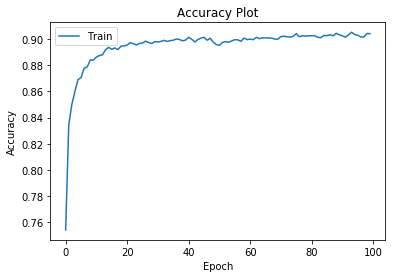

In [172]:
plt.plot(bn_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

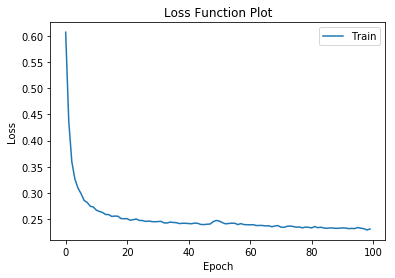

In [173]:
plt.plot(bn_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [174]:
train_bn_model_pred = bn_model.predict_classes(X_train)
test_bn_model_pred = bn_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [175]:
confusion_matrix_train = confusion_matrix(y_train, train_bn_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bn_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[33044     8]
 [ 7666    12]]
[[14163     2]
 [ 3281    10]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [176]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9997579571584171
Train TPR:  0.0015629070070330815
Train Accuracy:  0.8115885096980113
-----------------------
Test TNR:  0.999858806918461
Test TPR:  0.003038590094196293
Test Accuracy:  0.8119271310724107


#### model with weight decay

#### Find the best Weight Decay value

In [177]:
weight_decay_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [179]:
def l2_model_func(l2_value):
    # create model
    l2_model = Sequential()
    
    l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(l2_value), kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    
    # Compile model
    l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return l2_model   

In [180]:
hist_loss=[]

for weight_decay in weight_decay_list:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    l2_model = l2_model_func(weight_decay)
    
    #Fit the model
    l2_model_history = l2_model.fit(X_train, y_train, epochs=1,
                                    validation_split=0.2,steps_per_epoch=50,
                                    validation_steps=50)
    
    hist_loss.append(l2_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 8s 165ms/step - loss: 6.0678 - acc: 0.6967 - val_loss: 4.2945 - val_acc: 0.8110
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 9s 171ms/step - loss: 2.6423 - acc: 0.7029 - val_loss: 1.3242 - val_acc: 0.8135
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 8s 163ms/step - loss: 2.2865 - acc: 0.7038 - val_loss: 1.0136 - val_acc: 0.8127
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 9s 172ms/step - loss: 2.2642 - acc: 0.7038 - val_loss: 1.0269 - val_acc: 0.8127
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 9s 180ms/step - loss: 2.2424 - acc: 0.7038 - val_loss: 0.9513 - val_acc: 0.8132
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 

In [181]:
# Get the weight decay and loss Dataframe
loss_weight_decay = pd.DataFrame([weight_decay_list, hist_loss]).T  

#Give the coloumn names
loss_weight_decay.columns=['weight_decay', 'loss']

#Sort the values and reset the index
loss_weight_decay=loss_weight_decay.sort_values('loss').reset_index().drop('index',axis=1)
loss_weight_decay

,weight_decay,loss
0,1e-05,[2.242351863384247]
1,1e-06,[2.261854043006897]
2,0.0001,[2.264227387905121]
3,0.001,[2.2864536023139954]
4,0.01,[2.642281403541565]
5,0.1,[6.067787876129151]


In [182]:
#pick the top weight decay
best_params['best_l2_value'] = loss_weight_decay.loc[:,'weight_decay'][0]

In [183]:
best_params['best_l2_value']

1e-05

#### Build model with the best l2 value

In [184]:
np.random.seed(123)
tf.set_random_seed(123)

In [185]:
bst_l2_model = Sequential()

bst_l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(best_params['best_l2_value']),kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(best_params['best_l2_value']), kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(best_params['best_l2_value']), kernel_initializer="glorot_normal"))

# Compile model
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [186]:
bst_l2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_16 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [187]:
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [188]:
bst_l2_model_history = bst_l2_model.fit(X_train, y_train, epochs=100,
                                        batch_size=best_params['best_batch_size'], 
                                        validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 3s 98us/step - loss: 1.9384 - acc: 0.7263 - val_loss: 0.7524 - val_acc: 0.8094
Epoch 2/100
32584/32584 [==============================] - 1s 24us/step - loss: 1.0337 - acc: 0.8011 - val_loss: 0.4521 - val_acc: 0.8060
Epoch 3/100
32584/32584 [==============================] - 1s 23us/step - loss: 0.7259 - acc: 0.8133 - val_loss: 0.3859 - val_acc: 0.8113
Epoch 4/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.5768 - acc: 0.8152 - val_loss: 0.3650 - val_acc: 0.8069
Epoch 5/100
32584/32584 [==============================] - 1s 20us/step - loss: 0.5032 - acc: 0.8164 - val_loss: 0.3592 - val_acc: 0.8053
Epoch 6/100
32584/32584 [==============================] - 1s 20us/step - loss: 0.4546 - acc: 0.8152 - val_loss: 0.3573 - val_acc: 0.8053
Epoch 7/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.4428 - acc: 0.8137 - val_loss: 0.3465 - v

32584/32584 [==============================] - 1s 21us/step - loss: 0.2950 - acc: 0.8709 - val_loss: 0.2664 - val_acc: 0.8995
Epoch 60/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2971 - acc: 0.8675 - val_loss: 0.2720 - val_acc: 0.8918
Epoch 61/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.2952 - acc: 0.8682 - val_loss: 0.2735 - val_acc: 0.8970
Epoch 62/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.2971 - acc: 0.8694 - val_loss: 0.2694 - val_acc: 0.8998
Epoch 63/100
32584/32584 [==============================] - 1s 21us/step - loss: 0.2967 - acc: 0.8671 - val_loss: 0.2729 - val_acc: 0.8931
Epoch 64/100
32584/32584 [==============================] - 1s 20us/step - loss: 0.2908 - acc: 0.8706 - val_loss: 0.2670 - val_acc: 0.9012
Epoch 65/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.2948 - acc: 0.8693 - val_loss: 0.2676 - val_acc: 0.9003
Epoch 66/100
32584/32584 [==============

##### Plot

In [189]:
print(bst_l2_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


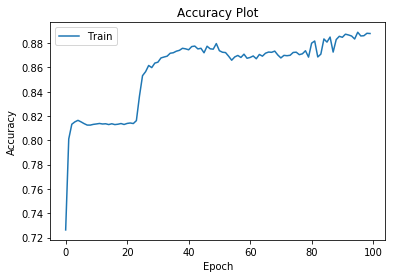

In [190]:
plt.plot(bst_l2_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

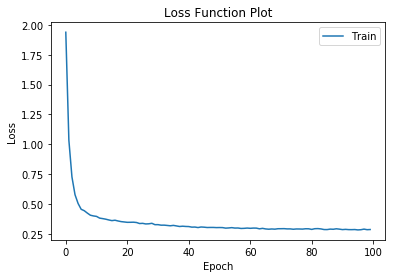

In [191]:
plt.plot(bst_l2_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [192]:
train_bst_l2_model_pred = bst_l2_model.predict_classes(X_train)
test_bst_l2_model_pred = bst_l2_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [193]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_l2_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_l2_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31509  1543]
 [ 2403  5275]]
[[13467   698]
 [ 1047  2244]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [194]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9533159869296866
Train TPR:  0.6870278718416254
Train Accuracy:  0.9031180947704395
-----------------------
Test TNR:  0.9507236145428875
Test TPR:  0.6818596171376481
Test Accuracy:  0.9000343721356554


In [195]:
best_params

{'best_learning_rate': 0.2703,
 'best_batch_size': 256,
 'best_h_activation': 'relu',
 'best_kernel_init': 'glorot_normal',
 'best_optimizer': 'adam',
 'best_l2_value': 1e-05}

### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/